# Diffusion Models Demo

#### Credit to original author who did a lot of the heavy lifting: J. Rafid Siddiqui (jrs@azaditech.com)


## Loading Data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from logging import warning
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
from helper_plot import hdr_plot_style
import torch
from utils import *
import logging
import warnings
import seaborn as sns
from tqdm import tqdm
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True
hdr_plot_style()

In [17]:
def make_iterable(arr):
    try:
        some_object_iterator = iter(arr)
    except TypeError as te:
        arr = [arr]
    return arr

def sample_gaussians(mu, sigma, n_samples=10000):
    """
    sample a gaussian mixture from len(mu)==len(sigma) gaussians.
    currently only 1-d supported
    """
    mu, sigma = make_iterable(mu), make_iterable(sigma)
    if type(mu) != torch.Tensor:
        mu = torch.tensor(mu)
    if type(sigma) != torch.Tensor:
        sigma = torch.tensor(sigma)
    assert mu.shape == sigma.shape, "mu and sigma must be the same shape!"
    samples = []
    components = len(mu)
    for i in range(components):
        mean, std  = mu[i], sigma[i]
        sample = torch.randn(n_samples//components) * std + mean
        samples.append(sample)

    samples = torch.concat(samples)
    idx = torch.randperm(samples.shape[0])
    samples = samples[idx]
    return samples

## Two main options supported in this version: either select a simple synthetic 2-d dataset and watch as we recreate it, or choose an arbitrary gaussian mixture and see the distribution re-emerge.

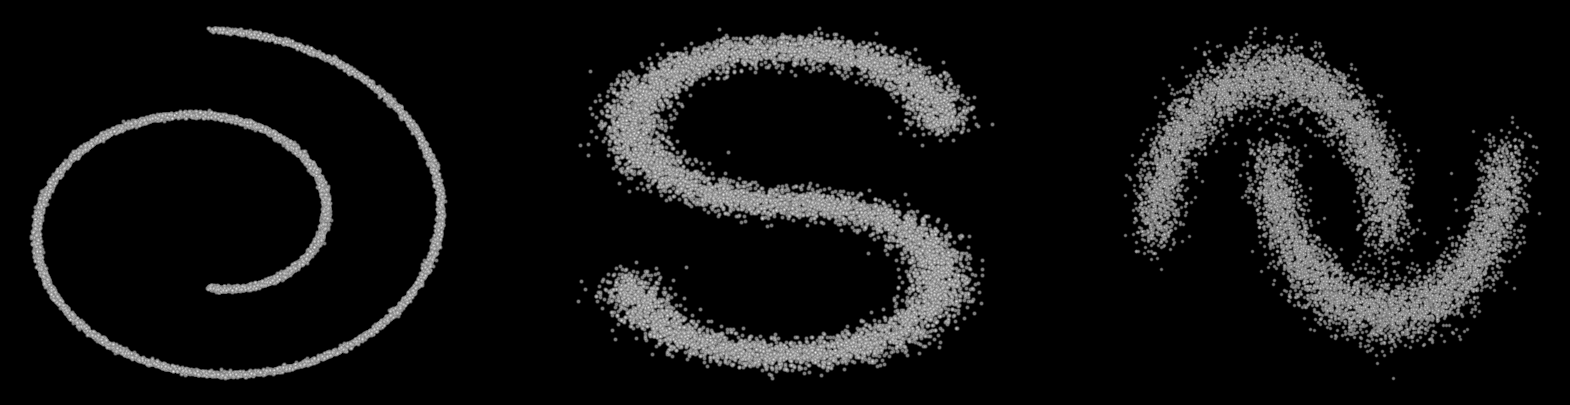

In [22]:
 # simple 2-d options
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]

moons, _ = make_moons(10**4, noise=0.1)


fig,axes = plt.subplots(1,3,figsize=(20,5))

data = swiss_roll.T

axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[0].axis('off')

data = s_curve.T
axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[1].axis('off')

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
axes[2].axis('off')


data = moons
input_size = 2
dataset = torch.Tensor(moons).float()

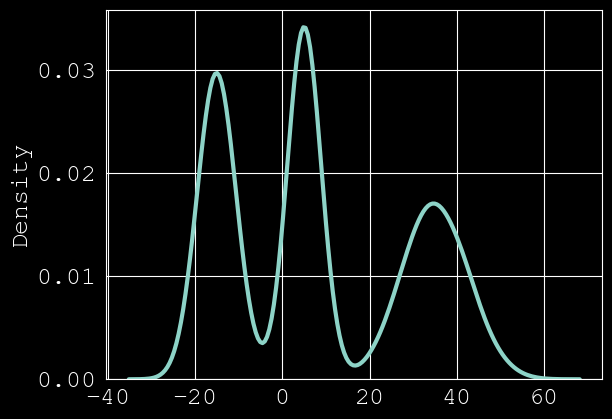

In [23]:
mus, sigmas = [-15, 5, 35], [3, 2, 7]
gaussian_data = sample_gaussians(mus, sigmas, 10000)
sns.kdeplot(gaussian_data)
plt.show()

# data = sample_gaussians(mus, sigmas, 10000)
# input_size = 1
# dataset = torch.Tensor(data.unsqueeze(-1)).float()

## Diffusion Models

![diffusion-image](https://github.com/azad-academy/denoising-diffusion-model/blob/main/images/diffusion.png?raw=1)

### Forward Diffusion

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

Substituting $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$: 

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Given the initial state, this makes it possible to draw sample at any desrired timestep without going through intermediate steps. Forward diffusion can also be written in terms of $x_0$ and the random noise $\epsilon \sim \mathcal{N}(0,1)$ [1]. This would be useful when performing denoising step later in the reverse diffusion.

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

In [24]:
num_steps = 1000
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [25]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [26]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [27]:
def normalize(x, x_max=None, x_min=None):
    if x_max is not None and x_min is not None:
        normed_x = ((x - x_min) / (x_max - x_min)) * 2 -1
    else:
        normed_x = ((x - x.min(dim=0).values) / (x.max(dim=0).values - x.min(dim=0).values)) * 2 -1
    return  normed_x

def denormalize(normed_x, x_max, x_min):
    x = ((normed_x + 1) / 2) * (x_max - x_min) + x_min
    return x

## Reverse Diffusion/Reconstruction

Unlike the forward diffusion, the reverse diffusion process requires training of a neural network model. We setup the necessary loss functions and training parameters and then perform the training.

## Training

### Training Loss

The original loss was proposed in Sohl-Dickstein et al. [1] as following:

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))  \\
&+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align} 


In order to improve the results, the authors in Ho et al. [2] proposed multiple improvements. Following Parameterization of mean is proposed: 

$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

further, variance is taken as constant and the step for reverse diffusion then becomes:

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$



After further improvements and simplifications the loss function becomes:

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

In [28]:
data_max , data_min = dataset.max(dim=0).values, dataset.min(dim=0).values
dataset = normalize(dataset)

100%|██████████| 11/11 [00:01<00:00,  6.18it/s]


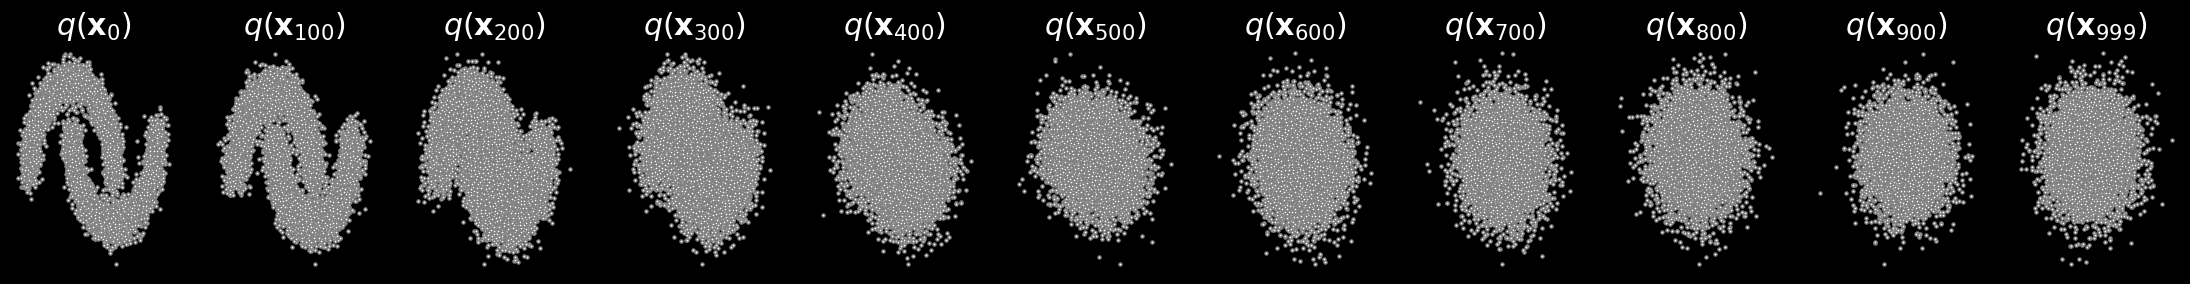

In [30]:
fig, axs = plt.subplots(1, 11, figsize=(28, 3))
for i in tqdm(range(11), position=0):
    q_i = q_x(dataset, torch.tensor([min(i * num_steps//10, num_steps-1)]))
    q_i = denormalize(q_i, data_max, data_min)
    if input_size == 1:
        sns.kdeplot(data, ax=axs[i], color='y', legend=False)
        sns.kdeplot(q_i, ax=axs[i],  color='b', legend=False)
    else:
        axs[i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(min(i * num_steps//10, num_steps-1))+'})$')

  0%|          | 0/5000 [00:00<?, ?it/s]

Current loss at step 0 = 0.9967987537384033


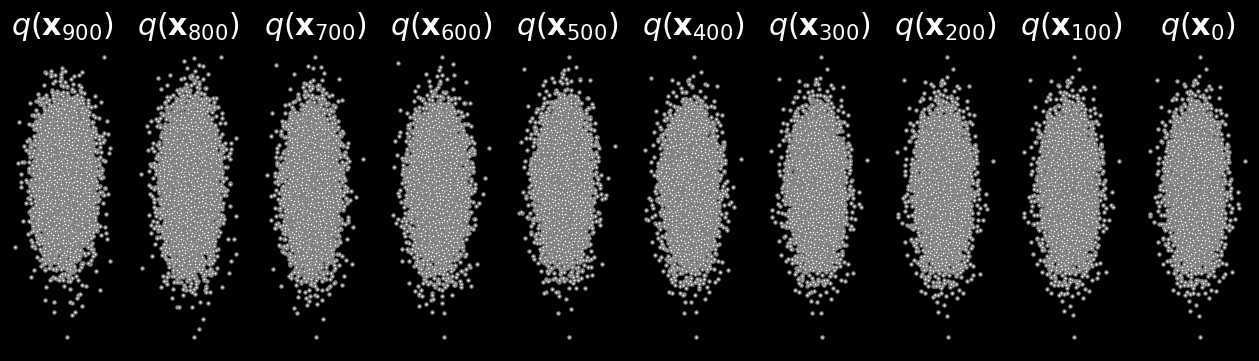

  5%|▍         | 249/5000 [00:20<05:26, 14.53it/s]

Current loss at step 250 = 0.4507557153701782


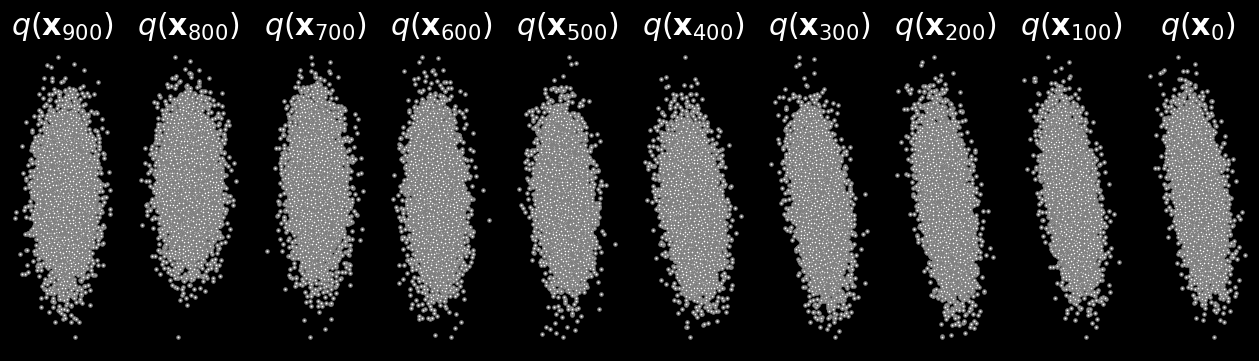

 10%|▉         | 499/5000 [00:40<05:15, 14.26it/s]

Current loss at step 500 = 0.43209877610206604


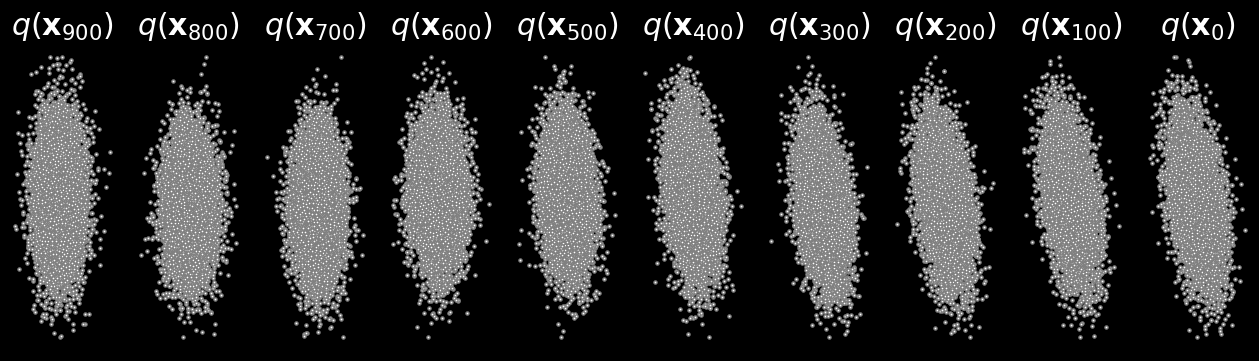

 15%|█▍        | 749/5000 [01:01<04:31, 15.65it/s]

Current loss at step 750 = 0.4591701626777649


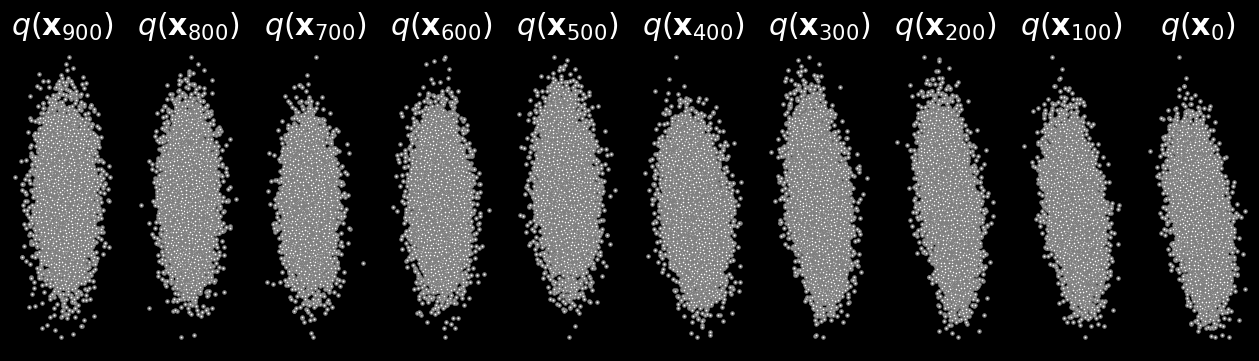

 20%|█▉        | 999/5000 [01:20<04:12, 15.85it/s]

Current loss at step 1000 = 0.42439091205596924


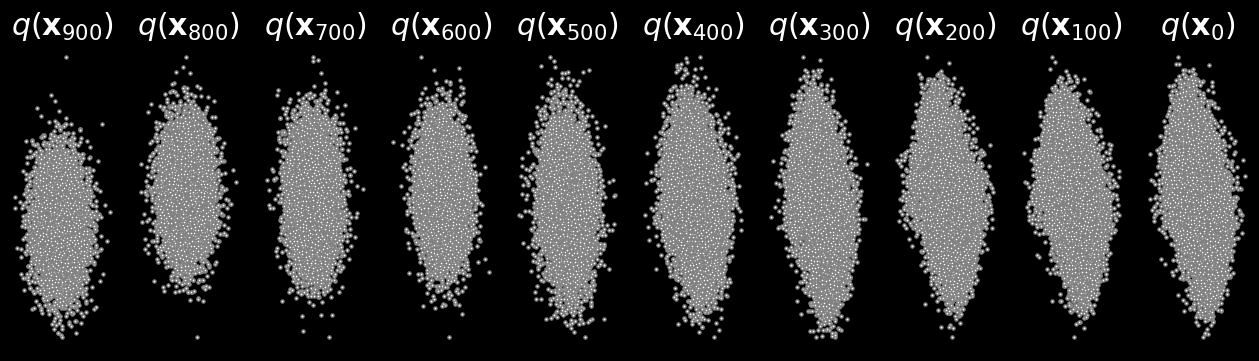

 25%|██▍       | 1249/5000 [01:40<04:04, 15.33it/s]

Current loss at step 1250 = 0.4232039451599121


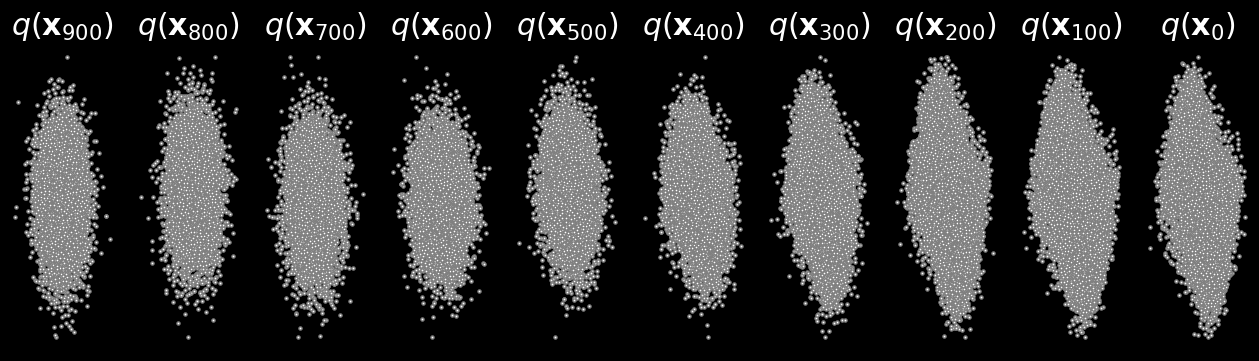

 30%|██▉       | 1499/5000 [02:00<04:09, 14.01it/s]

Current loss at step 1500 = 0.4330120384693146


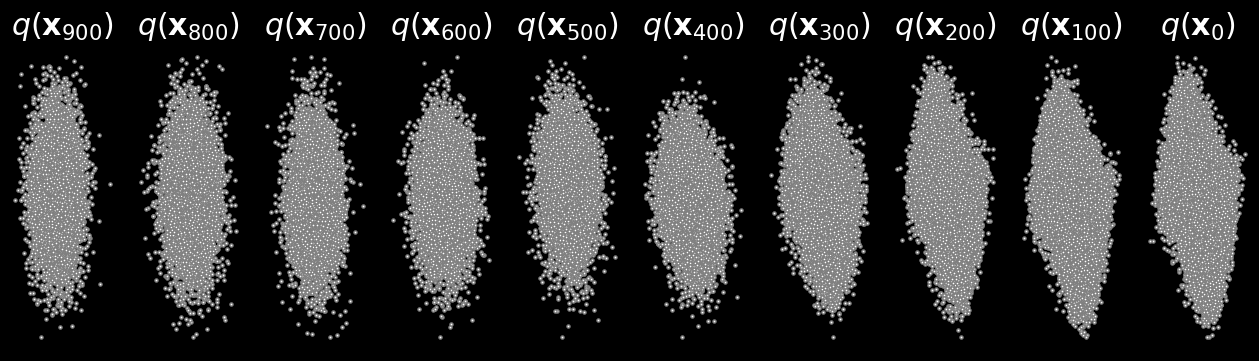

 35%|███▍      | 1749/5000 [02:20<03:26, 15.72it/s]

Current loss at step 1750 = 0.4347483515739441


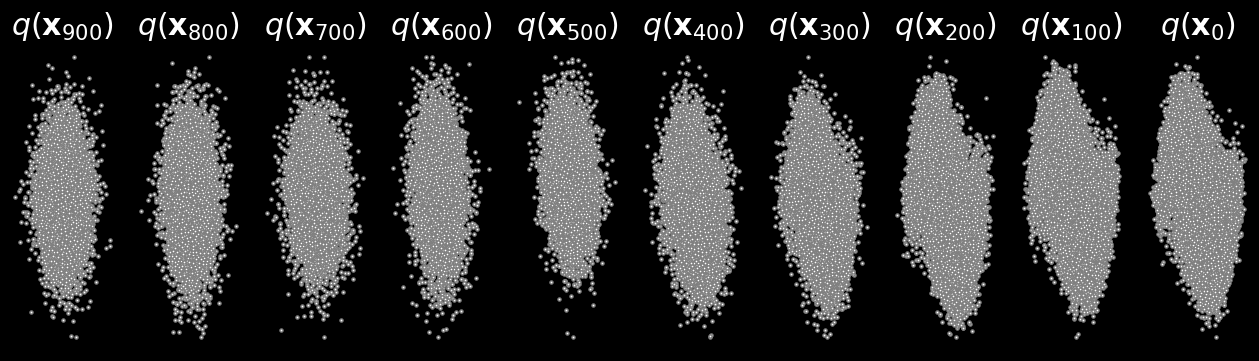

 40%|███▉      | 1999/5000 [02:40<03:18, 15.13it/s]

Current loss at step 2000 = 0.4416711628437042


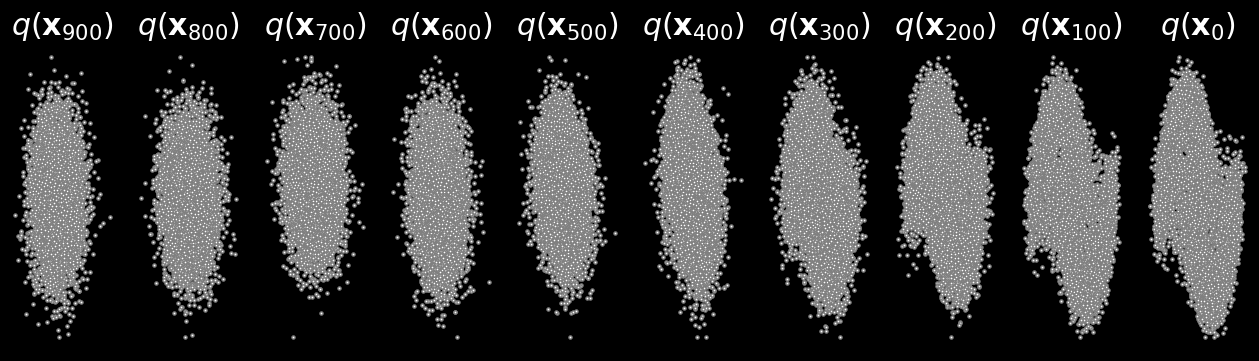

 45%|████▍     | 2249/5000 [02:59<02:55, 15.66it/s]

Current loss at step 2250 = 0.421430379152298


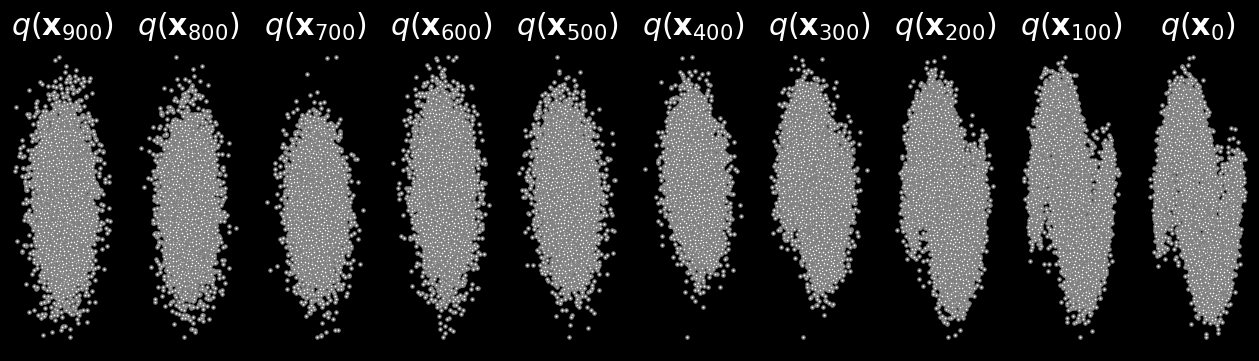

 50%|████▉     | 2499/5000 [03:19<02:56, 14.14it/s]

Current loss at step 2500 = 0.40054747462272644


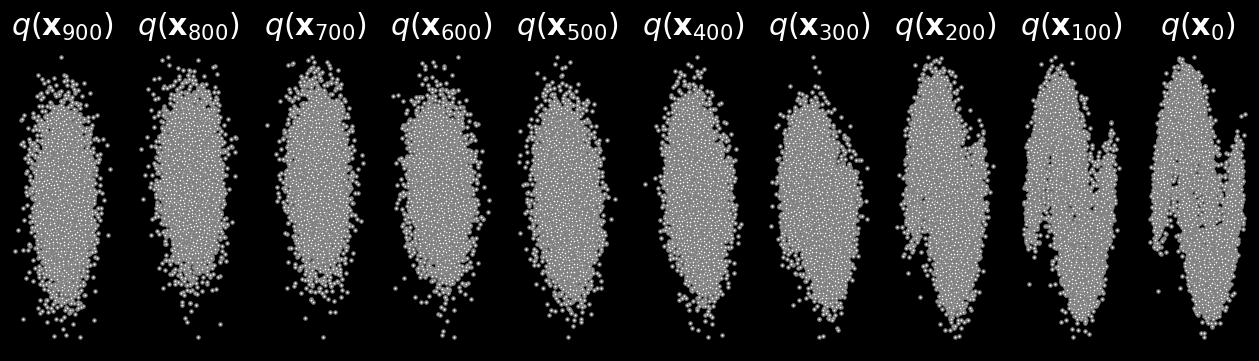

 55%|█████▍    | 2749/5000 [03:39<02:23, 15.71it/s]

Current loss at step 2750 = 0.4059692621231079


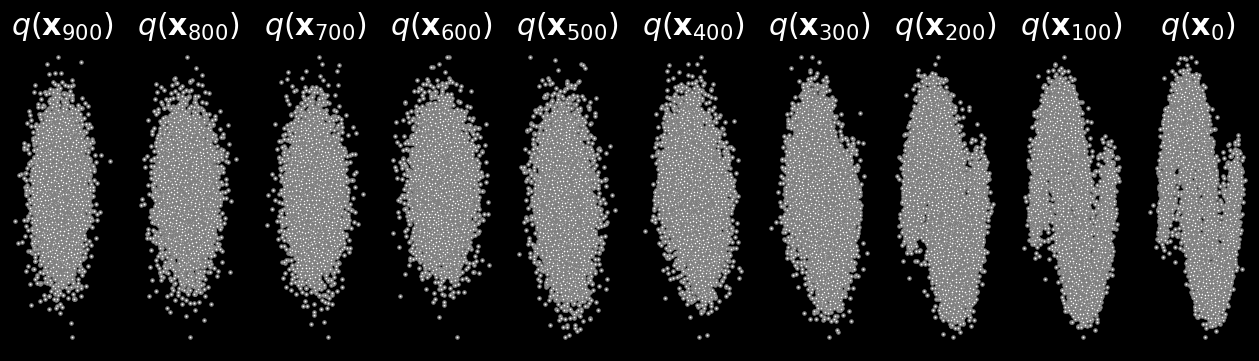

 60%|█████▉    | 2999/5000 [03:59<02:10, 15.34it/s]

Current loss at step 3000 = 0.4291316270828247


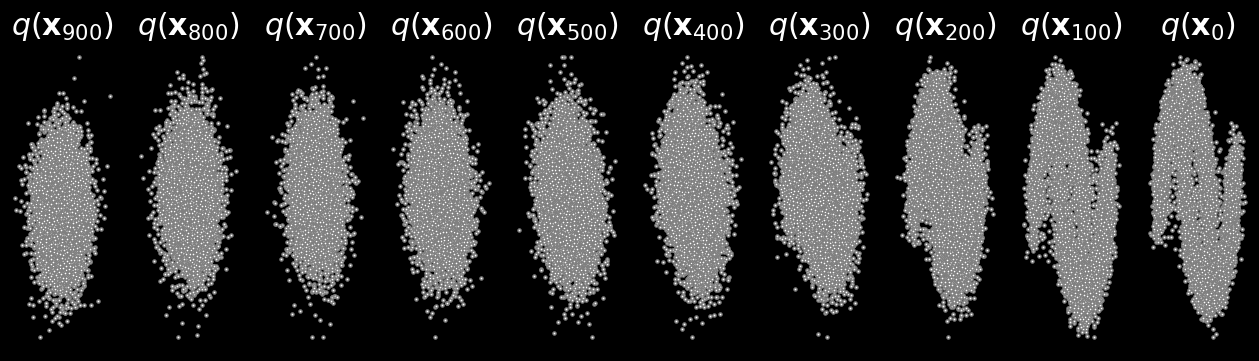

 65%|██████▍   | 3249/5000 [04:19<01:56, 15.05it/s]

Current loss at step 3250 = 0.3964293301105499


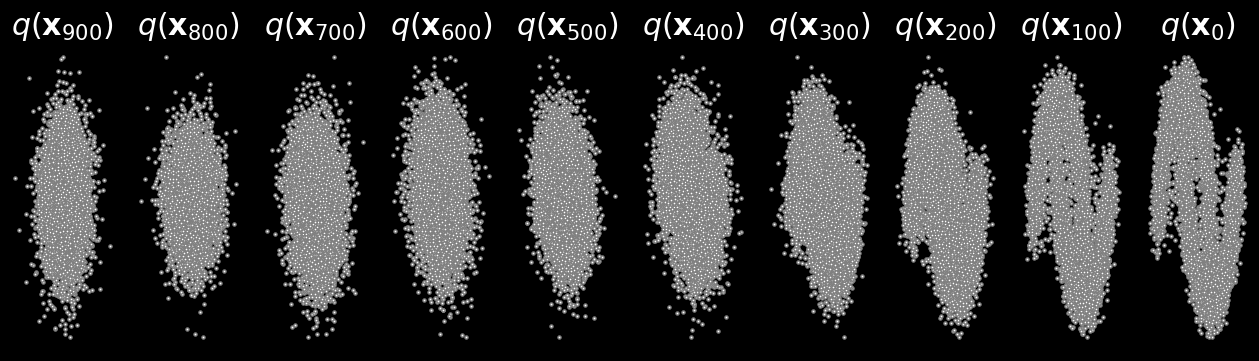

 70%|██████▉   | 3499/5000 [04:38<01:39, 15.14it/s]

Current loss at step 3500 = 0.406678169965744


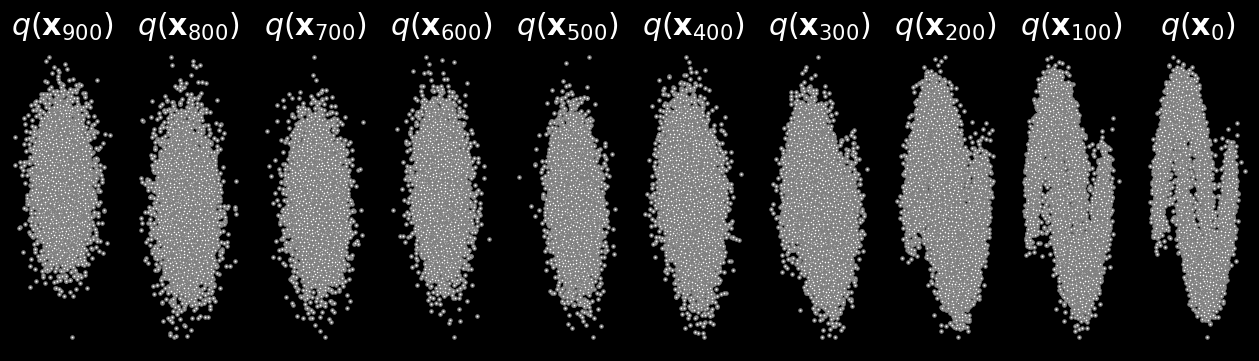

 75%|███████▍  | 3749/5000 [04:58<01:20, 15.55it/s]

Current loss at step 3750 = 0.4065416157245636


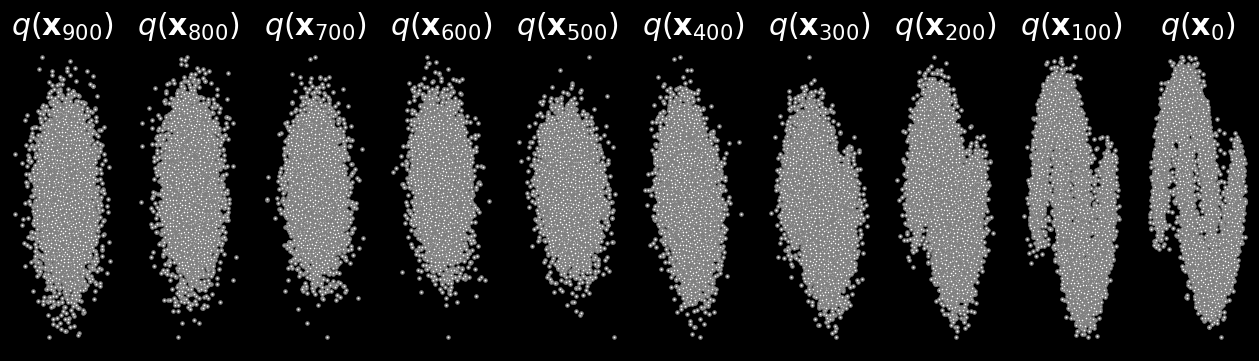

 80%|███████▉  | 3999/5000 [05:18<01:03, 15.73it/s]

Current loss at step 4000 = 0.39442041516304016


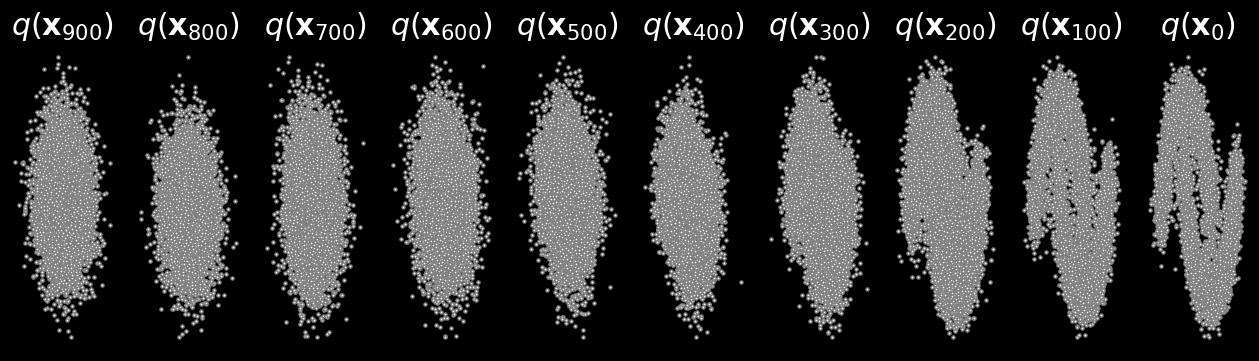

 85%|████████▍ | 4249/5000 [05:37<00:48, 15.44it/s]

Current loss at step 4250 = 0.418311208486557


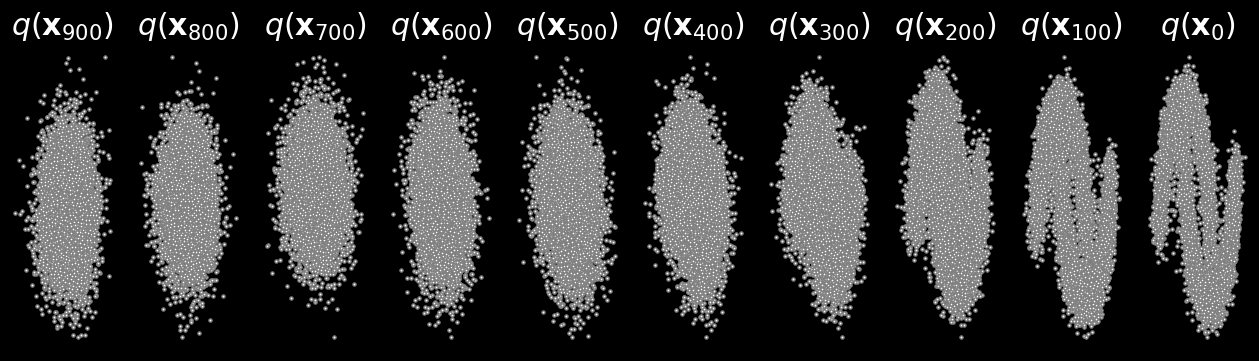

 90%|████████▉ | 4499/5000 [05:57<00:35, 13.93it/s]

Current loss at step 4500 = 0.41123443841934204


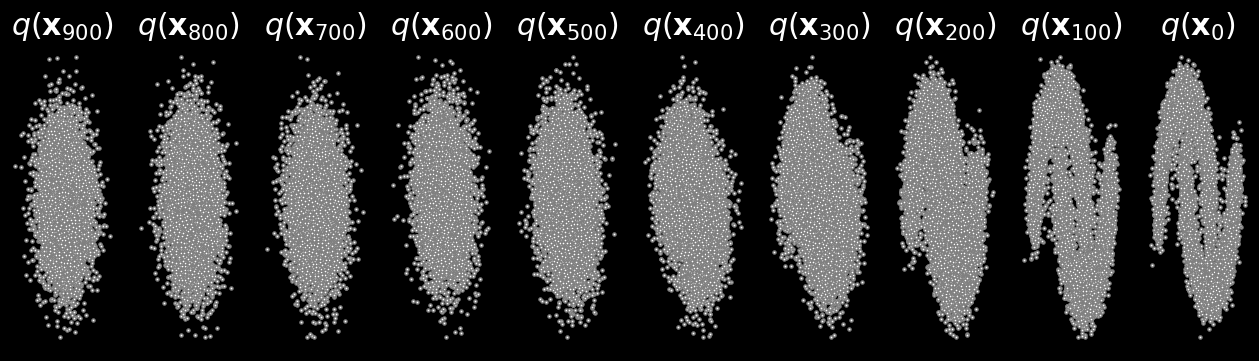

 95%|█████████▍| 4749/5000 [06:18<00:16, 15.40it/s]

Current loss at step 4750 = 0.3878615200519562


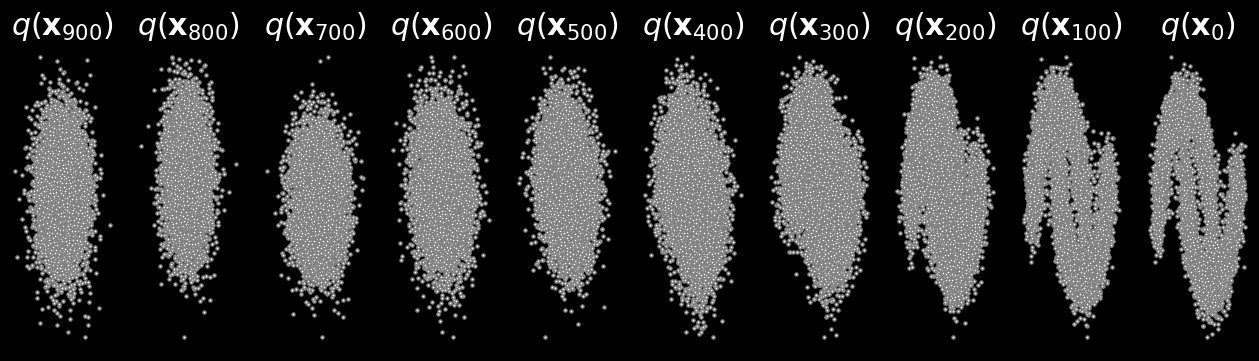

100%|██████████| 5000/5000 [06:38<00:00, 12.56it/s]


In [31]:
from model import ConditionalModel
from ema import EMA
import torch.optim as optim

device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = ConditionalModel(input_size, num_steps)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 2048 // input_size
epochs = 5000
for t in tqdm(range(epochs), position=0):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if  not t % (epochs//20):
        print(f'Current loss at step {t} = {loss.item()}')
        with torch.no_grad():
          x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(16, 4))
        if input_size == 1:
            sns.set(style="darkgrid")
        for i in range(1, 11):
            cur_x = x_seq[min(i * 100, num_steps-1)].detach()
            cur_x = denormalize(cur_x, data_max, data_min)
            if input_size == 1:
              sns.kdeplot(data, ax=axs[i-1], color='y', legend=False)
              sns.kdeplot(cur_x, ax=axs[i-1], color='b', legend=False)
            else:
              axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5)
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(num_steps - i*(num_steps//10))+'})$')
        if input_size == 1:
            plt.title('Original in yellow, predicted in blue', y=1.08)
        plt.show()
        plt.close()

In [ ]:
# Use to clear memory in case of cuda OOM failure

# import gc
# gc.collect()
# model = None
# with torch.no_grad():
#     torch.cuda.empty_cache()
# gc.collect()

## Animation

100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


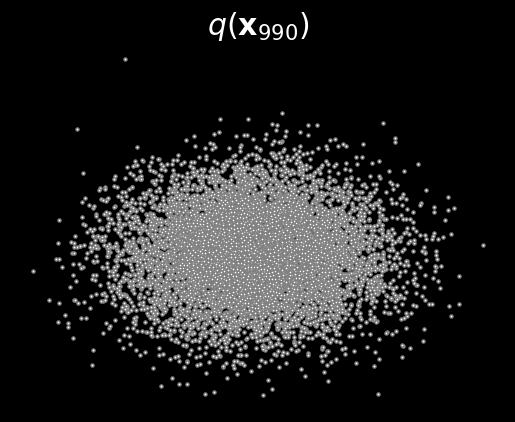

In [32]:
# Generating the forward image sequence

import io
from PIL import Image

imgs = []

for i in tqdm(range(0, num_steps, 10)):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    q_i = denormalize(q_i, data_max, data_min)
    if input_size == 1:
        sns.kdeplot(data, color='y', legend=False)
        sns.kdeplot(q_i,  color='b', legend=False)
    else:
        plt.scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5)
    plt.axis('off')
    plt.title('$q(\mathbf{x}_{'+str(i)+'})$', color='white')


    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)
    

100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


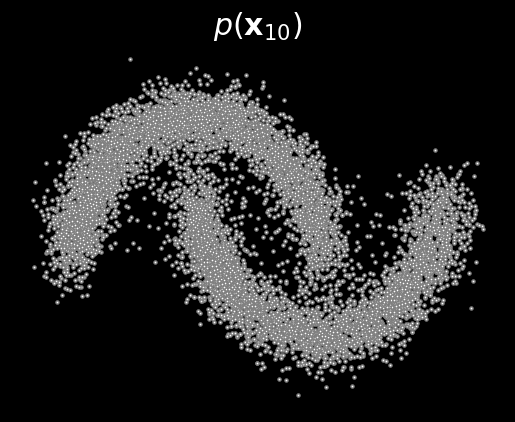

In [33]:
# Generating the reverse diffusion sequence

reverse = []

for i in tqdm(range(0, num_steps, 10)):
    plt.clf()
    cur_x = x_seq[i].detach()
    cur_x = denormalize(cur_x, data_max, data_min)
    if input_size == 1:
              sns.kdeplot(data, color='y', legend=False)
              sns.kdeplot(cur_x, color='b', legend=False)
    else:
        plt.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5)
    plt.axis('off')
    plt.title('$p(\mathbf{x}_{'+str(num_steps - i)+'})$', color='white')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [34]:
imgs = imgs + reverse

In [35]:
if input_size == 1:
    imgs[0].save(f"1_d_diffusion_{mus=}_{sigmas=}.gif", format='GIF', append_images=imgs,save_all=True, duration=100, loop=0)
else:
    imgs[0].save("2_d_diffusion.gif", format='GIF', append_images=imgs,save_all=True, duration=100, loop=0)

# References

[1] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. arXiv preprint arXiv:2006.11239.

[2] Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.